In [1]:
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
# run_query('''
# create or replace table max_dev.workspace.user_title_hours_watched_by_cohort_test 
# (
# request_date	VARCHAR, 
# viewable_id VARCHAR,
# segment_name VARCHAR,  
# hours_viewed	float
# );
# ''')

In [4]:
# run_query('''
# create or replace table max_dev.workspace.USER_TITLE_HOURS_WATCHED_BY_COHORT_SUBS 
# (
# segment_name VARCHAR,  
# start_date VARCHAR,
# end_date VARCHAR,
# DAYS_ON_HBO_MAX int,
# cohort_subs 	bigint
# );
# ''')

In [5]:
title_info = run_query('''
with offerings as (select DISTINCT
            case when season_number is not null then concat(title_name, ' S', season_number, ('E'), EPISODE_NUMBER_IN_SEASON)
            else title_name end as title_episode_name
    , title_name
    , rad.VIEWABLE_ID
    , concat(coalesce(rad.series_id, rad.viewable_id)) as title_id
    , rad.SERIES_ID
    , rad.SEASON_NUMBER
    , EPISODE_NUMBER_IN_SERIES
    , content_category
    , PRIMARY_GENRE_DESC
    , program_type
    , aod.release_year
    , ASSET_RUN_TIME
    , offering_start_date
    , offering_end_date
     FROM "MAX_PROD"."CATALOG"."ASSET_OFFERING_DIM" aod
LEFT JOIN "MAX_PROD"."CATALOG"."REPORTING_ASSET_DIM" rad ON aod.VIEWABLE_ID = rad.VIEWABLE_ID
where territory='HBO MAX DOMESTIC'
    and channel = 'HBO MAX SUBSCRIPTION'
    and OFFERING_TYPE = 'FEATURE'),

airtable as (select DISTINCT title_id 
    , MIN(PILLAR_GENRE) as PILLAR_GENRE -- multiple PILLAR GENRE assignments for a single VIEWABLE_ID, taking at random.
    from max_prod.catalog.airtable_content_strategy group by title_id),

offerings_by_date as (
select
     TITLE_NAME, title_episode_name
    , offerings.VIEWABLE_ID
    , offerings.title_id, offerings.SEASON_NUMBER
    , CONTENT_CATEGORY, program_type, release_year
    , am.home_territory_observed_medal as medal
    , CAST(FLOOR(COALESCE( (ASSET_RUN_TIME)/60/60 ,0)*(1000000*1.0)) AS DECIMAL(38,0))
          / CAST((1000000*1.0) AS DOUBLE PRECISION) as ASSET_RUN_TIME_HOURS -- to prevent floating point errors
    , case when to_date(offerings.offering_start_date) < '2020-05-27' THEN to_date('2020-05-27')
           ELSE to_date(offerings.offering_start_date)
           end as offering_start_date
    , to_date(offerings.offering_end_date) as offering_end_date
    , PRIMARY_GENRE_DESC
    , aos.PILLAR_GENRE as PILLAR_GENRE
FROM offerings
LEFT JOIN airtable aos ON (offerings.title_id = aos.title_id)
LEFT JOIN max_prod.content_analytics.asset_medals am 
        on offerings.title_id = am.title_id
        and coalesce(offerings.season_number,0) = coalesce(am.season,0)
WHERE 1=1
-- offerings.OFFERING_START_DATE > '2020-05-01'
-- and CURRENT_DATE() between (OFFERING_START_DATE) and (OFFERING_END_DATE)
ORDER BY VIEWABLE_ID)

SELECT * FROM offerings_by_date
''')

In [6]:
### DE-DUPTE THE TITLES

title_test_dedup = title_info.groupby(['viewable_id'])['offering_start_date'].min().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'offering_start_date'])

title_test_dedup = title_info.groupby(['viewable_id'])['offering_end_date'].max().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'offering_end_date'])

title_info['medal'] = title_info['medal'].fillna('None')
title_test_dedup = title_info.groupby(['viewable_id'])['medal'].max().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'medal'])


title_info = title_info.drop_duplicates()
title_info['season_number'] = title_info['season_number'].fillna(0)

In [7]:
#### SANITY CHECK
title_test = title_info.groupby(['viewable_id']).count()
title_test[title_test['title_name'] == 2]

,title_name,title_episode_name,title_id,season_number,content_category,program_type,release_year,medal,asset_run_time_hours,offering_start_date,offering_end_date,primary_genre_desc,pillar_genre
viewable_id,,,,,,,,,,,,,


In [15]:
title_series_info = title_info.groupby(['title_id', 'season_number'])['offering_start_date'].min().reset_index()

title_series_test = title_info.groupby(['title_id', 'season_number'])['asset_run_time_hours'].sum().reset_index()
title_series_info = title_series_info.merge(title_series_test, on = ['title_id', 'season_number'])

title_series_test = title_info.groupby(['title_id', 'season_number'])[['content_category', 'program_type', 'release_year', 'medal', 'pillar_genre']].max().reset_index()
title_series_info = title_series_info.merge(title_series_test, on = ['title_id', 'season_number'])

In [9]:
###### WHETHER WANT TO JOIN WITH VIWABLE ID LEVEL ############
# title_series_info = title_info[['title_name', 'viewable_id', 'title_id', 'season_number']].merge(
#                     title_series_info, on = ['title_id', 'season_number'])

In [17]:
# title_series_info[title_series_info['viewable_id']=='GWSL97g2lpwjDwgEAAAAl']

In [110]:
# import boto3
# import io

# def to_s3(filename, output_bucket, content):
#     client = boto3.client('s3')
#     client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
# output_bucket = 'hbo-outbound-datascience-content-dev'
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(output_bucket)

# def write_to_sf(df, file_name):
#     csv_buffer = io.StringIO()
#     df.to_csv(csv_buffer, index = False)
#     content = csv_buffer.getvalue()
#     filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
#     to_s3(filename, output_bucket, content)

In [111]:
# write_to_sf(title_series_info, 'title_series_info')

In [116]:
run_query('''
create or replace table max_dev.workspace.user_title_hours_watched_title_series_info 
(
title_name	VARCHAR,
viewable_id	VARCHAR,
title_id	VARCHAR,
season_number	int,
offering_start_date	VARCHAR,
asset_run_time_hours	float,
content_category	VARCHAR,
program_type	VARCHAR,
release_year	int,
medal	VARCHAR,
pillar_genre VARCHAR
);

''')

,status
0,Table USER_TITLE_HOURS_WATCHED_TITLE_SERIES_IN...


In [117]:
# run_query('''
# copy into max_dev.workspace.user_title_hours_watched_title_series_info
#     from(
#         select
#               $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/title_hours_viewed_retention/title_series_info.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/titl...,LOADED,42031,42031,42031,0,None,None,None,None


In [11]:
title_hours_viewed = run_query('''
SELECT co.segment_name,t.title_name, t.title_id, t.season_number
, co.request_date, DATEDIFF('DAY', t.offering_start_date::DATE, co.request_date::DATE) AS DAYS_ON_HBO_MAX
--,t.offering_start_date, t.asset_run_time_hours, t.content_category, t.program_type, t.release_year, t.medal, t.PILLAR_GENRE
,SUM(co.hours_viewed) AS daily_hours_viewed
,SUM(daily_hours_viewed) OVER (PARTITION BY title_id, season_number, segment_name order by DAYS_ON_HBO_MAX) as cumulative_hours_viewed
FROM MAX_DEV.WORKSPACE.user_title_hours_watched_by_cohort_test co
JOIN max_dev.workspace.user_title_hours_watched_title_series_info t
    on co.viewable_id = t.viewable_id
WHERE 1=1
AND segment_name IN ('Buzzy HBO Originals', 'Thrilling Action Movies')
AND DATEDIFF('DAY', t.offering_start_date::DATE, co.request_date::DATE) >= 0
-- AND TITLE_ID = 'GYsYeoAxKH8LCwgEAAAOR'
GROUP BY 1,2,3,4,5,6 --,7,8,9,10
ORDER BY segment_name, TITLE_ID, SEASON_NUMBER, DAYS_ON_HBO_MAX
''')

In [13]:
len(title_hours_viewed.title_id.unique())

7046

In [19]:
title_hours_viewed = title_hours_viewed.merge(title_series_info, on = ['title_id', 'season_number'])

In [22]:
title_hours_viewed['hvr'] = title_hours_viewed['cumulative_hours_viewed']/title_hours_viewed['asset_run_time_hours']

In [23]:
title_hours_viewed.medal.unique()

array(['None', 'Gold', 'Silver', 'Bronze', 'Platinum'], dtype=object)

In [25]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

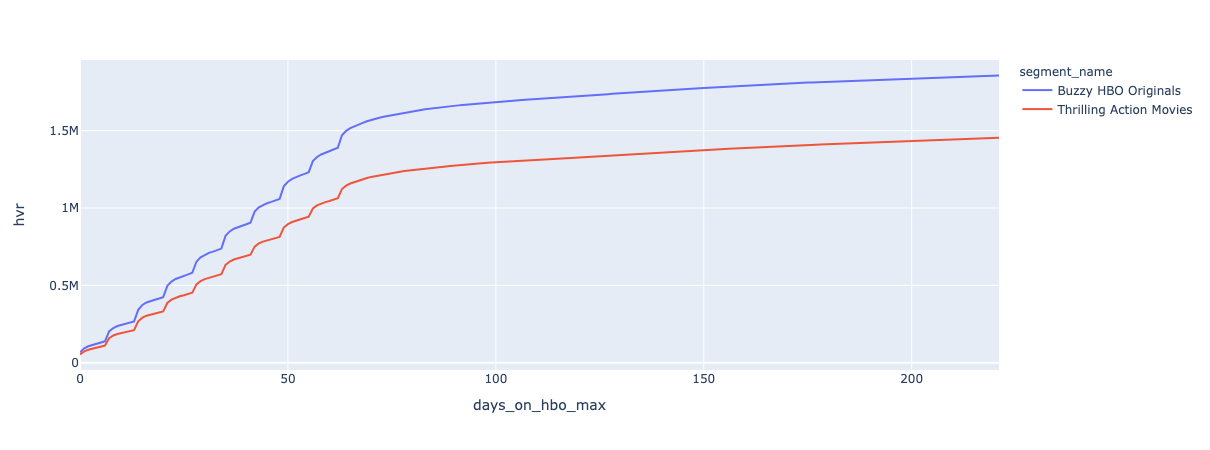

In [38]:

fig = px.line(plot, x="days_on_hbo_max", y="hvr", color='segment_name')
fig.show()

In [70]:
title_hours_viewed[(title_hours_viewed['title_name'] == 'The Batman')
                  &(title_hours_viewed['season_number'] == 0)].head(1)

,segment_name,title_name,title_id,season_number,request_date,days_on_hbo_max,daily_hours_viewed,cumulative_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,release_year,medal,pillar_genre,hvr
6615130,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-04-18,0,"328,953.35","328,953.35",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"112,015.92"


In [71]:
plot = title_hours_viewed[(title_hours_viewed['title_name'] == 'The Batman')
                  &(title_hours_viewed['season_number'] == 0)]

In [72]:
cohort_subs = pd.read_csv('cohort subs (1).csv')

In [73]:
cohort_subs.head()

,SEGMENT_NAME,START_DATE,END_DATE,DAYS_ON_HBO_MAX,COHORT_SUBS
0,Buzzy HBO Originals,2022-04-18,2022-04-18,0,1751170
1,Thrilling Action Movies,2022-04-18,2022-04-18,0,1446222
2,Thrilling Action Movies,2022-04-18,2022-04-25,7,1472979
3,Buzzy HBO Originals,2022-04-18,2022-04-25,7,1770080
4,Thrilling Action Movies,2022-04-18,2022-05-02,14,1488596


In [74]:
cohort_subs.columns = [i.lower() for i in cohort_subs.columns]

In [75]:
plot = plot.merge(cohort_subs[['segment_name', 'days_on_hbo_max', 'cohort_subs']],
                 on = ['segment_name', 'days_on_hbo_max'])

In [76]:
plot.head()

,segment_name,title_name,title_id,season_number,request_date,days_on_hbo_max,daily_hours_viewed,cumulative_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,release_year,medal,pillar_genre,hvr,cohort_subs
0,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-04-18,0,"328,953.35","328,953.35",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"112,015.92",1751170
1,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-04-25,7,"160,138.38","2,437,311.63",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"829,958.75",1770080
2,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-05-02,14,"71,925.19","3,091,028.58",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"1,052,563.89",1782927
3,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-05-09,21,"39,814.22","3,426,376.40",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"1,166,757.27",1793555
4,Buzzy HBO Originals,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,2022-05-16,28,"27,351.60","3,642,003.86",2022-04-18,2.94,movies,acquired,2022,Platinum,Action/Adventure,"1,240,183.21",1802248


In [79]:
plot['average_hour_viewed_before_runtime'] = plot['cumulative_hours_viewed']/plot['cohort_subs']

In [77]:
plot['average_hour_viewed'] = plot['hvr']/plot['cohort_subs']

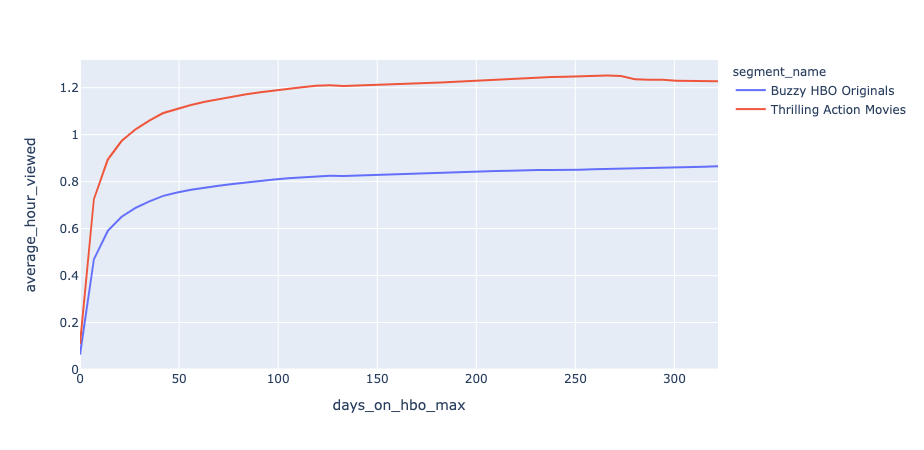

In [78]:
fig = px.line(plot, x="days_on_hbo_max", y="average_hour_viewed", color='segment_name')
fig.show()

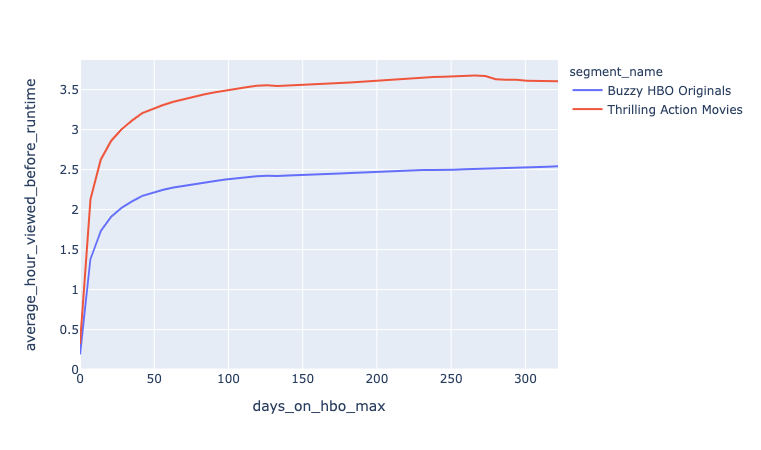

In [80]:
fig = px.line(plot, x="days_on_hbo_max", y="average_hour_viewed_before_runtime", color='segment_name')
fig.show()